In [1]:
import torch
from torchvision.transforms import ToTensor, Compose, Resize, Lambda, RandomHorizontalFlip, RandomRotation
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib.pyplot import subplots
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint


In [2]:
torch.cuda.empty_cache()


In [3]:
import requests
requests.get("https://huggingface.co").status_code


200

In [4]:
from datasets import load_dataset

dataset = load_dataset("microsoft/cats_vs_dogs", download_mode="force_redownload")


# Exibe um exemplo
print(dataset)
print(dataset["train"][0])




c:\Users\Lucas\miniconda3\envs\gpu_nb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Generating train split: 100%|██████████| 23410/23410 [00:01<00:00, 16847.76 examples/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2B4B5C1C9D0>, 'labels': 0}


In [5]:
split = dataset["train"].train_test_split(test_size=0.2, seed=42)

train = split["train"]
test = split["test"]

subset_size = 1000
use_subset = False

if use_subset:
    train = train.select(range(subset_size))
    test = test.select(range(subset_size))
print("Train size:", len(train))
print("Test size:", len(test))


Train size: 18728
Test size: 4682


In [ ]:
transform = Compose([
    Resize((224, 224)),
    Lambda(lambda img: img.convert("RGB")), 
    RandomHorizontalFlip(p=0.5),   # espelha horizontalmente com 50% de chance
    RandomRotation(degrees=10),
    ToTensor()
])

train_X = torch.stack([transform(x["image"]) for x in train])
test_X = torch.stack([transform(x["image"]) for x in test])


train_y = torch.tensor([x["labels"] for x in train])
test_y = torch.tensor([x["labels"] for x in test])


train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

In [ ]:
batch_size = 8
num_workers = 4
train_size = int(len(train) * 0.8)
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [8]:
for idx , (X ,y) in enumerate(train_loader):
    print('X: ', X.shape)
    print('Y: ', y.shape)
    if idx >= 1:
       break   

X:  torch.Size([8, 3, 224, 224])
Y:  torch.Size([8])
X:  torch.Size([8, 3, 224, 224])
Y:  torch.Size([8])


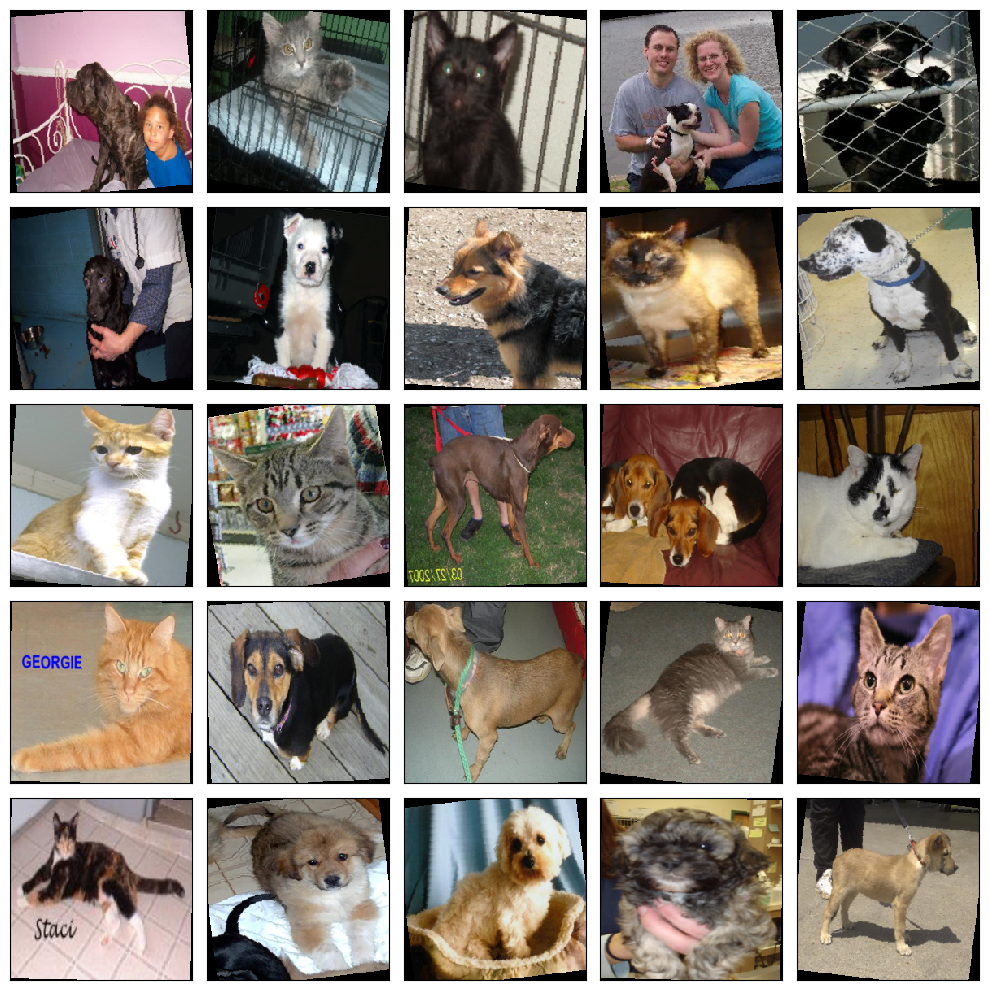

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
rng = np.random.default_rng(4)
indices = rng.choice(len(train_dataset), size=25, replace=False).reshape(5, 5)

for i in range(5):
    for j in range(5):
        idx = indices[i, j]
        image = train_dataset[idx][0].permute(1, 2, 0).numpy()  # [C,H,W] → [H,W,C]
        axes[i, j].imshow(image, interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()


In [31]:
print(set(x["labels"] for x in train))  # deve retornar {0, 1}


{0, 1}


In [32]:
import time
from torch.utils.data import DataLoader

def benchmark_num_workers(dataset, batch_size=32, max_workers=8):
    for num_workers in range(0, max_workers+1):
        loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
        start = time.time()
        for i, batch in enumerate(loader):
            if i >= 10:
                break
        end = time.time()
        print(f"num_workers = {num_workers}: Tempo = {end - start:.2f} segundos")


In [33]:
benchmark_num_workers(train_dataset, batch_size=8, max_workers=8)


num_workers = 0: Tempo = 0.09 segundos
num_workers = 1: Tempo = 2.67 segundos
num_workers = 2: Tempo = 2.46 segundos
num_workers = 3: Tempo = 2.60 segundos
num_workers = 4: Tempo = 2.72 segundos
num_workers = 5: Tempo = 2.96 segundos
num_workers = 6: Tempo = 3.36 segundos
num_workers = 7: Tempo = 3.64 segundos
num_workers = 8: Tempo = 3.88 segundos


In [ ]:
class BuildingBlock(nn.Module):
    def __init__(self ,
                    in_channels ,
                    out_channels):
        super(BuildingBlock , self).__init__ ()
        self.conv = nn.Conv2d(in_channels=in_channels ,
                                out_channels=out_channels ,
                                kernel_size =(3 ,3),
                                padding='same')
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU ()
        self.pool = nn.MaxPool2d(kernel_size =(2 ,2))
    def forward(self , x):
      return self.pool(self.activation(self.bn(self.conv(x))))

In [30]:
class CVD_Model(nn.Module):
    def __init__(self):
        super(CVD_Model , self).__init__ ()
        sizes = [(3 ,32) ,
        (32 ,64) ,
        (64 ,128) ,
        (128 ,256),
        (256, 512)]
        self.conv = nn.Sequential (*[ BuildingBlock(in_ , out_)
                                        for in_ , out_ in sizes ])
        self.output = nn.Sequential(nn.Dropout (0.5) ,
                                    nn.Linear (7*7*512 , 1024) ,
                                    nn.ReLU (),
                                    nn.Linear(1024, 512),
                                    nn.ReLU(),
                                    nn.Linear (512, 2))
    def forward(self , x):
        val = self.conv(x)
        val = torch.flatten(val , start_dim =1)
        return self.output(val)

In [31]:
class CVD_Small(nn.Module):
    """2 blocos conv + 2 lineares"""
    def __init__(self, num_classes=2):
        super().__init__()
        sizes = [(3, 32),   
                 (32, 64)]  
        self.conv = nn.Sequential(
            *[BuildingBlock(cin, cout) for cin, cout in sizes]
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # --- PARTE FULLY‑CONNECTED ---
        self.output = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 128),  # 1ª camada linear
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)  # 2ª camada linear (saída)
        )
    def forward(self, x):
        x = self.conv(x)       # [B, 64, H/4, W/4]
        x = self.avgpool(x)        # [B, 64, 1, 1]
        x = torch.flatten(x, 1)    # [B, 64]
        x = self.output(x)     # [B, num_classes]
        return x

In [32]:
cvd_model = CVD_Model()
summary(cvd_model ,
input_data= torch.randn(1, 3, 224, 224),
col_names =['input_size',
'output_size',
'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVD_Model                                [1, 3, 224, 224]          [1, 2]                    --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 512, 7, 7]            --
│    └─BuildingBlock: 2-1                [1, 3, 224, 224]          [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 3, 224, 224]          [1, 32, 224, 224]         896
│    │    └─BatchNorm2d: 3-2             [1, 32, 224, 224]         [1, 32, 224, 224]         64
│    │    └─ReLU: 3-3                    [1, 32, 224, 224]         [1, 32, 224, 224]         --
│    │    └─MaxPool2d: 3-4               [1, 32, 224, 224]         [1, 32, 112, 112]         --
│    └─BuildingBlock: 2-2                [1, 32, 112, 112]         [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 32, 112, 112]         [1, 64, 112, 112]         18,496
│    │    └─BatchNorm2d: 3-6  

In [33]:
cvd_model_small = CVD_Small()
summary(cvd_model_small ,
input_data= torch.randn(1, 3, 224, 224),
col_names =['input_size',
'output_size',
'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVD_Small                                [1, 3, 224, 224]          [1, 2]                    --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 64, 56, 56]           --
│    └─BuildingBlock: 2-1                [1, 3, 224, 224]          [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 3, 224, 224]          [1, 32, 224, 224]         896
│    │    └─BatchNorm2d: 3-2             [1, 32, 224, 224]         [1, 32, 224, 224]         64
│    │    └─ReLU: 3-3                    [1, 32, 224, 224]         [1, 32, 224, 224]         --
│    │    └─MaxPool2d: 3-4               [1, 32, 224, 224]         [1, 32, 112, 112]         --
│    └─BuildingBlock: 2-2                [1, 32, 112, 112]         [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 32, 112, 112]         [1, 64, 112, 112]         18,496
│    │    └─BatchNorm2d: 3-6  

In [34]:
class LitCVDModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CVD_Model() 
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
        

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001)

In [35]:
class LitCVDSmall(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CVD_Small() 
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
        

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001)

In [17]:
model = LitCVDModel()


checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="best-cvd-model",
    verbose=True
)

trainer = Trainer(
    accelerator="auto",  
    devices=1,
    max_epochs=120,
    precision=16,         
    log_every_n_steps=10,
    callbacks=[checkpoint_callback]
    
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

c:\Users\Lucas\miniconda3\envs\gpu_nb\Lib\site-packages\lightning\fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Lucas\miniconda3\envs\gpu_nb\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Lucas\miniconda3\envs\gpu_nb\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\Lucas\miniconda3\envs\gpu_nb\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 118/118 [00:27<00:00,  4.30it/s, v_num=6]

Epoch 0, global step 118: 'val_acc' reached 0.53017 (best 0.53017), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 1: 100%|██████████| 118/118 [00:25<00:00,  4.54it/s, v_num=6]

Epoch 1, global step 236: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 118/118 [00:27<00:00,  4.37it/s, v_num=6]

Epoch 2, global step 354: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 3, global step 472: 'val_acc' reached 0.63134 (best 0.63134), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 4: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s, v_num=6]

Epoch 4, global step 590: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 118/118 [00:25<00:00,  4.55it/s, v_num=6]

Epoch 5, global step 708: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 118/118 [00:25<00:00,  4.64it/s, v_num=6]

Epoch 6, global step 826: 'val_acc' reached 0.72264 (best 0.72264), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 7: 100%|██████████| 118/118 [00:27<00:00,  4.35it/s, v_num=6]

Epoch 7, global step 944: 'val_acc' was not in top 1


Epoch 8: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s, v_num=6]

Epoch 8, global step 1062: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s, v_num=6]

Epoch 9, global step 1180: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s, v_num=6]

Epoch 10, global step 1298: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s, v_num=6]

Epoch 11, global step 1416: 'val_acc' reached 0.78991 (best 0.78991), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 12: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s, v_num=6]

Epoch 12, global step 1534: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 118/118 [00:25<00:00,  4.66it/s, v_num=6]

Epoch 13, global step 1652: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 118/118 [00:26<00:00,  4.53it/s, v_num=6]

Epoch 14, global step 1770: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 118/118 [00:26<00:00,  4.50it/s, v_num=6]

Epoch 15, global step 1888: 'val_acc' reached 0.80513 (best 0.80513), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 16: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s, v_num=6]

Epoch 16, global step 2006: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 118/118 [00:25<00:00,  4.58it/s, v_num=6]

Epoch 17, global step 2124: 'val_acc' reached 0.86225 (best 0.86225), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 18: 100%|██████████| 118/118 [00:26<00:00,  4.44it/s, v_num=6]

Epoch 18, global step 2242: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s, v_num=6]

Epoch 19, global step 2360: 'val_acc' reached 0.89883 (best 0.89883), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 20: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s, v_num=6]

Epoch 20, global step 2478: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 118/118 [00:25<00:00,  4.64it/s, v_num=6]

Epoch 21, global step 2596: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 118/118 [00:24<00:00,  4.79it/s, v_num=6]

Epoch 22, global step 2714: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s, v_num=6]

Epoch 23, global step 2832: 'val_acc' reached 0.92552 (best 0.92552), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 24: 100%|██████████| 118/118 [00:26<00:00,  4.50it/s, v_num=6]

Epoch 24, global step 2950: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 118/118 [00:26<00:00,  4.39it/s, v_num=6]

Epoch 25, global step 3068: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 118/118 [00:25<00:00,  4.69it/s, v_num=6]

Epoch 26, global step 3186: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s, v_num=6]

Epoch 27, global step 3304: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 118/118 [00:26<00:00,  4.48it/s, v_num=6]

Epoch 28, global step 3422: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 118/118 [00:26<00:00,  4.45it/s, v_num=6]

Epoch 29, global step 3540: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 118/118 [00:25<00:00,  4.61it/s, v_num=6]

Epoch 30, global step 3658: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 118/118 [00:25<00:00,  4.61it/s, v_num=6]

Epoch 31, global step 3776: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 118/118 [00:25<00:00,  4.70it/s, v_num=6]

Epoch 32, global step 3894: 'val_acc' reached 0.92792 (best 0.92792), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 33: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 33, global step 4012: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s, v_num=6]

Epoch 34, global step 4130: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 118/118 [00:25<00:00,  4.55it/s, v_num=6]

Epoch 35, global step 4248: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s, v_num=6]

Epoch 36, global step 4366: 'val_acc' was not in top 1


Epoch 37: 100%|██████████| 118/118 [00:26<00:00,  4.47it/s, v_num=6]

Epoch 37, global step 4484: 'val_acc' was not in top 1


Epoch 38: 100%|██████████| 118/118 [00:26<00:00,  4.53it/s, v_num=6]

Epoch 38, global step 4602: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 118/118 [00:25<00:00,  4.67it/s, v_num=6]

Epoch 39, global step 4720: 'val_acc' reached 0.93326 (best 0.93326), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 40: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 40, global step 4838: 'val_acc' was not in top 1


Epoch 41: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s, v_num=6]

Epoch 41, global step 4956: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 118/118 [00:26<00:00,  4.49it/s, v_num=6]

Epoch 42, global step 5074: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 118/118 [00:26<00:00,  4.51it/s, v_num=6]

Epoch 43, global step 5192: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s, v_num=6]

Epoch 44, global step 5310: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 45, global step 5428: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 118/118 [00:25<00:00,  4.65it/s, v_num=6]

Epoch 46, global step 5546: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s, v_num=6]

Epoch 47, global step 5664: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s, v_num=6]

Epoch 48, global step 5782: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 118/118 [00:25<00:00,  4.62it/s, v_num=6]

Epoch 49, global step 5900: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 118/118 [00:26<00:00,  4.48it/s, v_num=6]

Epoch 50, global step 6018: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s, v_num=6]

Epoch 51, global step 6136: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 118/118 [00:25<00:00,  4.62it/s, v_num=6]

Epoch 52, global step 6254: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s, v_num=6]

Epoch 53, global step 6372: 'val_acc' was not in top 1


Epoch 54: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 54, global step 6490: 'val_acc' reached 0.93433 (best 0.93433), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 55: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s, v_num=6]

Epoch 55, global step 6608: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 118/118 [00:26<00:00,  4.54it/s, v_num=6]

Epoch 56, global step 6726: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 118/118 [00:27<00:00,  4.32it/s, v_num=6]

Epoch 57, global step 6844: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 118/118 [00:26<00:00,  4.47it/s, v_num=6]

Epoch 58, global step 6962: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 118/118 [00:26<00:00,  4.41it/s, v_num=6]

Epoch 59, global step 7080: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 118/118 [00:25<00:00,  4.65it/s, v_num=6]

Epoch 60, global step 7198: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 118/118 [00:26<00:00,  4.53it/s, v_num=6]

Epoch 61, global step 7316: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 118/118 [00:25<00:00,  4.55it/s, v_num=6]

Epoch 62, global step 7434: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 118/118 [00:25<00:00,  4.61it/s, v_num=6]

Epoch 63, global step 7552: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s, v_num=6]

Epoch 64, global step 7670: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 118/118 [00:24<00:00,  4.73it/s, v_num=6]

Epoch 65, global step 7788: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 118/118 [00:27<00:00,  4.36it/s, v_num=6]

Epoch 66, global step 7906: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 118/118 [00:27<00:00,  4.33it/s, v_num=6]

Epoch 67, global step 8024: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s, v_num=6]

Epoch 68, global step 8142: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 118/118 [00:25<00:00,  4.55it/s, v_num=6]

Epoch 69, global step 8260: 'val_acc' was not in top 1


Epoch 70: 100%|██████████| 118/118 [00:25<00:00,  4.55it/s, v_num=6]

Epoch 70, global step 8378: 'val_acc' was not in top 1


Epoch 71: 100%|██████████| 118/118 [00:26<00:00,  4.53it/s, v_num=6]

Epoch 71, global step 8496: 'val_acc' was not in top 1


Epoch 72: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s, v_num=6]

Epoch 72, global step 8614: 'val_acc' was not in top 1


Epoch 73: 100%|██████████| 118/118 [00:25<00:00,  4.65it/s, v_num=6]

Epoch 73, global step 8732: 'val_acc' was not in top 1


Epoch 74: 100%|██████████| 118/118 [00:25<00:00,  4.67it/s, v_num=6]

Epoch 74, global step 8850: 'val_acc' was not in top 1


Epoch 75: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s, v_num=6]

Epoch 75, global step 8968: 'val_acc' was not in top 1


Epoch 76: 100%|██████████| 118/118 [00:24<00:00,  4.76it/s, v_num=6]

Epoch 76, global step 9086: 'val_acc' was not in top 1


Epoch 77: 100%|██████████| 118/118 [00:25<00:00,  4.69it/s, v_num=6]

Epoch 77, global step 9204: 'val_acc' was not in top 1


Epoch 78: 100%|██████████| 118/118 [00:25<00:00,  4.58it/s, v_num=6]

Epoch 78, global step 9322: 'val_acc' was not in top 1


Epoch 79: 100%|██████████| 118/118 [00:25<00:00,  4.58it/s, v_num=6]

Epoch 79, global step 9440: 'val_acc' was not in top 1


Epoch 80: 100%|██████████| 118/118 [00:27<00:00,  4.34it/s, v_num=6]

Epoch 80, global step 9558: 'val_acc' was not in top 1


Epoch 81: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s, v_num=6]

Epoch 81, global step 9676: 'val_acc' was not in top 1


Epoch 82: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s, v_num=6]

Epoch 82, global step 9794: 'val_acc' was not in top 1


Epoch 83: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 83, global step 9912: 'val_acc' was not in top 1


Epoch 84: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s, v_num=6]

Epoch 84, global step 10030: 'val_acc' was not in top 1


Epoch 85: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s, v_num=6]

Epoch 85, global step 10148: 'val_acc' was not in top 1


Epoch 86: 100%|██████████| 118/118 [00:25<00:00,  4.66it/s, v_num=6]

Epoch 86, global step 10266: 'val_acc' was not in top 1


Epoch 87: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 87, global step 10384: 'val_acc' was not in top 1


Epoch 88: 100%|██████████| 118/118 [00:26<00:00,  4.45it/s, v_num=6]

Epoch 88, global step 10502: 'val_acc' was not in top 1


Epoch 89: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 89, global step 10620: 'val_acc' was not in top 1


Epoch 90: 100%|██████████| 118/118 [00:25<00:00,  4.55it/s, v_num=6]

Epoch 90, global step 10738: 'val_acc' was not in top 1


Epoch 91: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s, v_num=6]

Epoch 91, global step 10856: 'val_acc' was not in top 1


Epoch 92: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s, v_num=6]

Epoch 92, global step 10974: 'val_acc' was not in top 1


Epoch 93: 100%|██████████| 118/118 [00:25<00:00,  4.58it/s, v_num=6]

Epoch 93, global step 11092: 'val_acc' was not in top 1


Epoch 94: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s, v_num=6]

Epoch 94, global step 11210: 'val_acc' was not in top 1


Epoch 95: 100%|██████████| 118/118 [00:26<00:00,  4.53it/s, v_num=6]

Epoch 95, global step 11328: 'val_acc' was not in top 1


Epoch 96: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s, v_num=6]

Epoch 96, global step 11446: 'val_acc' was not in top 1


Epoch 97: 100%|██████████| 118/118 [00:26<00:00,  4.51it/s, v_num=6]

Epoch 97, global step 11564: 'val_acc' was not in top 1


Epoch 98: 100%|██████████| 118/118 [00:26<00:00,  4.44it/s, v_num=6]

Epoch 98, global step 11682: 'val_acc' was not in top 1


Epoch 99: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s, v_num=6]

Epoch 99, global step 11800: 'val_acc' was not in top 1


Epoch 100: 100%|██████████| 118/118 [00:26<00:00,  4.39it/s, v_num=6]

Epoch 100, global step 11918: 'val_acc' reached 0.93833 (best 0.93833), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_6\\checkpoints\\best-cvd-model.ckpt' as top 1


Epoch 101: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s, v_num=6]

Epoch 101, global step 12036: 'val_acc' was not in top 1


Epoch 102: 100%|██████████| 118/118 [00:24<00:00,  4.76it/s, v_num=6]

Epoch 102, global step 12154: 'val_acc' was not in top 1


Epoch 103: 100%|██████████| 118/118 [00:25<00:00,  4.58it/s, v_num=6]

Epoch 103, global step 12272: 'val_acc' was not in top 1


Epoch 104: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 104, global step 12390: 'val_acc' was not in top 1


Epoch 105: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s, v_num=6]

Epoch 105, global step 12508: 'val_acc' was not in top 1


Epoch 106: 100%|██████████| 118/118 [00:25<00:00,  4.61it/s, v_num=6]

Epoch 106, global step 12626: 'val_acc' was not in top 1


Epoch 107: 100%|██████████| 118/118 [00:25<00:00,  4.64it/s, v_num=6]

Epoch 107, global step 12744: 'val_acc' was not in top 1


Epoch 108: 100%|██████████| 118/118 [00:26<00:00,  4.50it/s, v_num=6]

Epoch 108, global step 12862: 'val_acc' was not in top 1


Epoch 109: 100%|██████████| 118/118 [00:28<00:00,  4.17it/s, v_num=6]

Epoch 109, global step 12980: 'val_acc' was not in top 1


Epoch 110: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s, v_num=6]

Epoch 110, global step 13098: 'val_acc' was not in top 1


Epoch 111: 100%|██████████| 118/118 [00:25<00:00,  4.66it/s, v_num=6]

Epoch 111, global step 13216: 'val_acc' was not in top 1


Epoch 112: 100%|██████████| 118/118 [00:27<00:00,  4.29it/s, v_num=6]

Epoch 112, global step 13334: 'val_acc' was not in top 1


Epoch 113: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s, v_num=6]

Epoch 113, global step 13452: 'val_acc' was not in top 1


Epoch 114: 100%|██████████| 118/118 [00:25<00:00,  4.66it/s, v_num=6]

Epoch 114, global step 13570: 'val_acc' was not in top 1


Epoch 115: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s, v_num=6]

Epoch 115, global step 13688: 'val_acc' was not in top 1


Epoch 116: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s, v_num=6]

Epoch 116, global step 13806: 'val_acc' was not in top 1


Epoch 117: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s, v_num=6]

Epoch 117, global step 13924: 'val_acc' was not in top 1


Epoch 118: 100%|██████████| 118/118 [00:25<00:00,  4.62it/s, v_num=6]

Epoch 118, global step 14042: 'val_acc' was not in top 1


Epoch 119: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s, v_num=6]

Epoch 119, global step 14160: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s, v_num=6]


In [18]:
model_small = LitCVDSmall()


checkpoint_callback_small = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="best-cvd-model-small",
    verbose=True
)

trainer = Trainer(
    accelerator="auto",  
    devices=1,
    max_epochs=120,
    precision=16,         
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_small]
    
)

trainer.fit(model_small, train_dataloaders=train_loader, val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | CVD_Small        | 28.2 K | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
28.2 K    Trainable params
0         Non-trainable params
28.2 K    Total params
0.113     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s, v_num=7]        

Epoch 0, global step 118: 'val_acc' reached 0.58436 (best 0.58436), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 1: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s, v_num=7]

Epoch 1, global step 236: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 118/118 [00:21<00:00,  5.57it/s, v_num=7]

Epoch 2, global step 354: 'val_acc' reached 0.59637 (best 0.59637), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 3: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s, v_num=7]

Epoch 3, global step 472: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s, v_num=7]

Epoch 4, global step 590: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s, v_num=7]

Epoch 5, global step 708: 'val_acc' reached 0.61799 (best 0.61799), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 6: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s, v_num=7]

Epoch 6, global step 826: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 118/118 [00:21<00:00,  5.61it/s, v_num=7]

Epoch 7, global step 944: 'val_acc' was not in top 1


Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s, v_num=7]

Epoch 8, global step 1062: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s, v_num=7]

Epoch 9, global step 1180: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s, v_num=7]

Epoch 10, global step 1298: 'val_acc' reached 0.63001 (best 0.63001), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 11: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s, v_num=7]

Epoch 11, global step 1416: 'val_acc' reached 0.65216 (best 0.65216), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 12: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s, v_num=7]

Epoch 12, global step 1534: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s, v_num=7]

Epoch 13, global step 1652: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s, v_num=7]

Epoch 14, global step 1770: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s, v_num=7]

Epoch 15, global step 1888: 'val_acc' was not in top 1


Epoch 16: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s, v_num=7]

Epoch 16, global step 2006: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s, v_num=7]

Epoch 17, global step 2124: 'val_acc' was not in top 1


Epoch 18: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s, v_num=7]

Epoch 18, global step 2242: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s, v_num=7]

Epoch 19, global step 2360: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s, v_num=7]

Epoch 20, global step 2478: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s, v_num=7]

Epoch 21, global step 2596: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 118/118 [00:21<00:00,  5.62it/s, v_num=7]

Epoch 22, global step 2714: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 118/118 [00:21<00:00,  5.55it/s, v_num=7]

Epoch 23, global step 2832: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 118/118 [00:20<00:00,  5.62it/s, v_num=7]

Epoch 24, global step 2950: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s, v_num=7]

Epoch 25, global step 3068: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s, v_num=7]

Epoch 26, global step 3186: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 118/118 [00:22<00:00,  5.30it/s, v_num=7]

Epoch 27, global step 3304: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s, v_num=7]

Epoch 28, global step 3422: 'val_acc' reached 0.65456 (best 0.65456), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 29: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s, v_num=7]

Epoch 29, global step 3540: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s, v_num=7]

Epoch 30, global step 3658: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s, v_num=7]

Epoch 31, global step 3776: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s, v_num=7]

Epoch 32, global step 3894: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s, v_num=7]

Epoch 33, global step 4012: 'val_acc' reached 0.67005 (best 0.67005), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 34: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s, v_num=7]

Epoch 34, global step 4130: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s, v_num=7]

Epoch 35, global step 4248: 'val_acc' reached 0.68446 (best 0.68446), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 36: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s, v_num=7]

Epoch 36, global step 4366: 'val_acc' was not in top 1


Epoch 37: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s, v_num=7]

Epoch 37, global step 4484: 'val_acc' was not in top 1


Epoch 38: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s, v_num=7]

Epoch 38, global step 4602: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 118/118 [00:21<00:00,  5.57it/s, v_num=7]

Epoch 39, global step 4720: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s, v_num=7]

Epoch 40, global step 4838: 'val_acc' was not in top 1


Epoch 41: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s, v_num=7]

Epoch 41, global step 4956: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s, v_num=7]

Epoch 42, global step 5074: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s, v_num=7]

Epoch 43, global step 5192: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 118/118 [00:22<00:00,  5.34it/s, v_num=7]

Epoch 44, global step 5310: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s, v_num=7]

Epoch 45, global step 5428: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 118/118 [00:20<00:00,  5.90it/s, v_num=7]

Epoch 46, global step 5546: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s, v_num=7]

Epoch 47, global step 5664: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s, v_num=7]

Epoch 48, global step 5782: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s, v_num=7]

Epoch 49, global step 5900: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s, v_num=7]

Epoch 50, global step 6018: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s, v_num=7]

Epoch 51, global step 6136: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s, v_num=7]

Epoch 52, global step 6254: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s, v_num=7]

Epoch 53, global step 6372: 'val_acc' was not in top 1


Epoch 54: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s, v_num=7]

Epoch 54, global step 6490: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s, v_num=7]

Epoch 55, global step 6608: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s, v_num=7]

Epoch 56, global step 6726: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s, v_num=7]

Epoch 57, global step 6844: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s, v_num=7]

Epoch 58, global step 6962: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s, v_num=7]

Epoch 59, global step 7080: 'val_acc' reached 0.72077 (best 0.72077), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 60: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s, v_num=7]

Epoch 60, global step 7198: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 118/118 [00:19<00:00,  5.90it/s, v_num=7]

Epoch 61, global step 7316: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s, v_num=7]

Epoch 62, global step 7434: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s, v_num=7]

Epoch 63, global step 7552: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s, v_num=7]

Epoch 64, global step 7670: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s, v_num=7]

Epoch 65, global step 7788: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s, v_num=7]

Epoch 66, global step 7906: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s, v_num=7]

Epoch 67, global step 8024: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s, v_num=7]

Epoch 68, global step 8142: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 118/118 [00:21<00:00,  5.52it/s, v_num=7]

Epoch 69, global step 8260: 'val_acc' was not in top 1


Epoch 70: 100%|██████████| 118/118 [00:22<00:00,  5.30it/s, v_num=7]

Epoch 70, global step 8378: 'val_acc' was not in top 1


Epoch 71: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s, v_num=7]

Epoch 71, global step 8496: 'val_acc' was not in top 1


Epoch 72: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s, v_num=7]

Epoch 72, global step 8614: 'val_acc' was not in top 1


Epoch 73: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s, v_num=7]

Epoch 73, global step 8732: 'val_acc' was not in top 1


Epoch 74: 100%|██████████| 118/118 [00:23<00:00,  5.10it/s, v_num=7]

Epoch 74, global step 8850: 'val_acc' was not in top 1


Epoch 75: 100%|██████████| 118/118 [00:23<00:00,  4.92it/s, v_num=7]

Epoch 75, global step 8968: 'val_acc' was not in top 1


Epoch 76: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s, v_num=7]

Epoch 76, global step 9086: 'val_acc' was not in top 1


Epoch 77: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s, v_num=7]

Epoch 77, global step 9204: 'val_acc' was not in top 1


Epoch 78: 100%|██████████| 118/118 [00:27<00:00,  4.36it/s, v_num=7]

Epoch 78, global step 9322: 'val_acc' was not in top 1


Epoch 79: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s, v_num=7]

Epoch 79, global step 9440: 'val_acc' was not in top 1


Epoch 80: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s, v_num=7]

Epoch 80, global step 9558: 'val_acc' was not in top 1


Epoch 81: 100%|██████████| 118/118 [00:24<00:00,  4.76it/s, v_num=7]

Epoch 81, global step 9676: 'val_acc' was not in top 1


Epoch 82: 100%|██████████| 118/118 [00:25<00:00,  4.70it/s, v_num=7]

Epoch 82, global step 9794: 'val_acc' was not in top 1


Epoch 83: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s, v_num=7]

Epoch 83, global step 9912: 'val_acc' was not in top 1


Epoch 84: 100%|██████████| 118/118 [00:22<00:00,  5.25it/s, v_num=7]

Epoch 84, global step 10030: 'val_acc' was not in top 1


Epoch 85: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s, v_num=7]

Epoch 85, global step 10148: 'val_acc' was not in top 1


Epoch 86: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s, v_num=7]

Epoch 86, global step 10266: 'val_acc' was not in top 1


Epoch 87: 100%|██████████| 118/118 [00:22<00:00,  5.13it/s, v_num=7]

Epoch 87, global step 10384: 'val_acc' was not in top 1


Epoch 88: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s, v_num=7]

Epoch 88, global step 10502: 'val_acc' was not in top 1


Epoch 89: 100%|██████████| 118/118 [00:23<00:00,  5.00it/s, v_num=7]

Epoch 89, global step 10620: 'val_acc' was not in top 1


Epoch 90: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s, v_num=7]

Epoch 90, global step 10738: 'val_acc' was not in top 1


Epoch 91: 100%|██████████| 118/118 [00:22<00:00,  5.14it/s, v_num=7]

Epoch 91, global step 10856: 'val_acc' was not in top 1


Epoch 92: 100%|██████████| 118/118 [00:23<00:00,  5.06it/s, v_num=7]

Epoch 92, global step 10974: 'val_acc' was not in top 1


Epoch 93: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s, v_num=7]

Epoch 93, global step 11092: 'val_acc' was not in top 1


Epoch 94: 100%|██████████| 118/118 [00:22<00:00,  5.25it/s, v_num=7]

Epoch 94, global step 11210: 'val_acc' was not in top 1


Epoch 95: 100%|██████████| 118/118 [00:22<00:00,  5.25it/s, v_num=7]

Epoch 95, global step 11328: 'val_acc' reached 0.72718 (best 0.72718), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 96: 100%|██████████| 118/118 [00:23<00:00,  5.08it/s, v_num=7]

Epoch 96, global step 11446: 'val_acc' was not in top 1


Epoch 97: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s, v_num=7]

Epoch 97, global step 11564: 'val_acc' was not in top 1


Epoch 98: 100%|██████████| 118/118 [00:21<00:00,  5.38it/s, v_num=7]

Epoch 98, global step 11682: 'val_acc' was not in top 1


Epoch 99: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s, v_num=7]

Epoch 99, global step 11800: 'val_acc' was not in top 1


Epoch 100: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s, v_num=7]

Epoch 100, global step 11918: 'val_acc' was not in top 1


Epoch 101: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s, v_num=7]

Epoch 101, global step 12036: 'val_acc' was not in top 1


Epoch 102: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s, v_num=7]

Epoch 102, global step 12154: 'val_acc' reached 0.72851 (best 0.72851), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_7\\checkpoints\\best-cvd-model-small.ckpt' as top 1


Epoch 103: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s, v_num=7]

Epoch 103, global step 12272: 'val_acc' was not in top 1


Epoch 104: 100%|██████████| 118/118 [00:22<00:00,  5.33it/s, v_num=7]

Epoch 104, global step 12390: 'val_acc' was not in top 1


Epoch 105: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s, v_num=7]

Epoch 105, global step 12508: 'val_acc' was not in top 1


Epoch 106: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s, v_num=7]

Epoch 106, global step 12626: 'val_acc' was not in top 1


Epoch 107: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s, v_num=7]

Epoch 107, global step 12744: 'val_acc' was not in top 1


Epoch 108: 100%|██████████| 118/118 [00:21<00:00,  5.37it/s, v_num=7]

Epoch 108, global step 12862: 'val_acc' was not in top 1


Epoch 109: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s, v_num=7]

Epoch 109, global step 12980: 'val_acc' was not in top 1


Epoch 110: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s, v_num=7]

Epoch 110, global step 13098: 'val_acc' was not in top 1


Epoch 111: 100%|██████████| 118/118 [00:23<00:00,  5.00it/s, v_num=7]

Epoch 111, global step 13216: 'val_acc' was not in top 1


Epoch 112: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s, v_num=7]

Epoch 112, global step 13334: 'val_acc' was not in top 1


Epoch 113: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s, v_num=7]

Epoch 113, global step 13452: 'val_acc' was not in top 1


Epoch 114: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s, v_num=7]

Epoch 114, global step 13570: 'val_acc' was not in top 1


Epoch 115: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s, v_num=7]

Epoch 115, global step 13688: 'val_acc' was not in top 1


Epoch 116: 100%|██████████| 118/118 [00:23<00:00,  5.03it/s, v_num=7]

Epoch 116, global step 13806: 'val_acc' was not in top 1


Epoch 117: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s, v_num=7]

Epoch 117, global step 13924: 'val_acc' was not in top 1


Epoch 118: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s, v_num=7]

Epoch 118, global step 14042: 'val_acc' was not in top 1


Epoch 119: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s, v_num=7]

Epoch 119, global step 14160: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s, v_num=7]


In [19]:
model = LitCVDModel.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(model, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Lucas\miniconda3\envs\gpu_nb\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 37/37 [00:02<00:00, 15.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9374198913574219
        test_loss           0.47252359986305237
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.47252359986305237, 'test_acc': 0.9374198913574219}]

In [20]:
model_small = LitCVDSmall.load_from_checkpoint(checkpoint_callback_small.best_model_path)
trainer.test(model_small, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 37/37 [00:01<00:00, 19.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7313113808631897
        test_loss           0.5510209202766418
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5510209202766418, 'test_acc': 0.7313113808631897}]

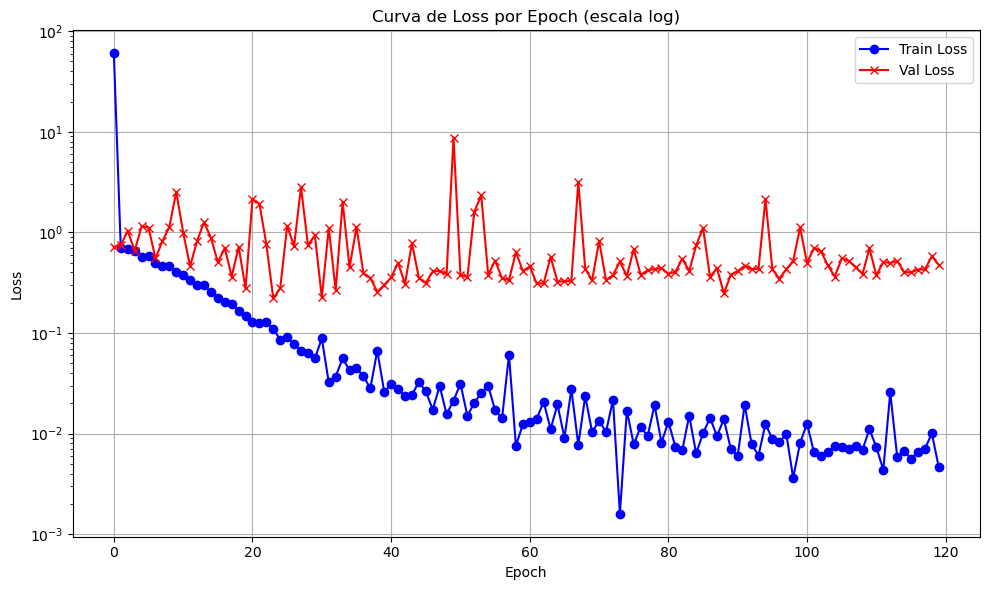

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para seu log
log_path = "lightning_logs/version_6/metrics.csv"

# Carrega o CSV
df = pd.read_csv(log_path)

# Remove linhas onde as colunas estão vazias
train = df[df["train_loss"].notnull()]
val = df[df["val_loss"].notnull()]

# Cria o gráfico
plt.figure(figsize=(10, 6))
plt.plot(train["epoch"], train["train_loss"], label="Train Loss", color="blue", marker='o')
plt.plot(val["epoch"], val["val_loss"], label="Val Loss", color="red", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss por Epoch (escala log)")
plt.yscale("log")  # <- Aqui
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


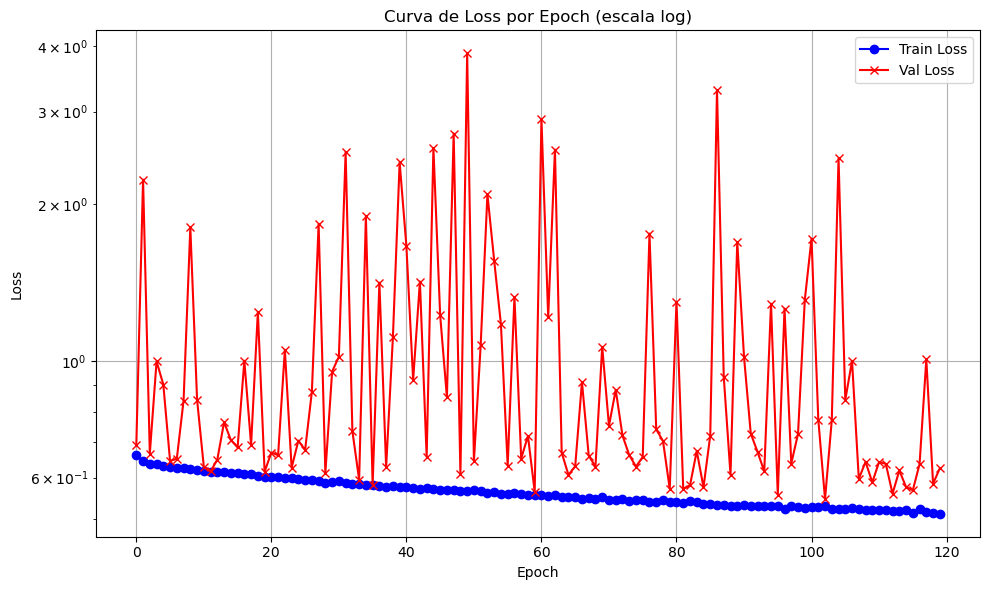

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para seu log
log_path = "lightning_logs/version_7/metrics.csv"

# Carrega o CSV
df = pd.read_csv(log_path)

# Remove linhas onde as colunas estão vazias
train = df[df["train_loss"].notnull()]
val = df[df["val_loss"].notnull()]

# Cria o gráfico
plt.figure(figsize=(10, 6))
plt.plot(train["epoch"], train["train_loss"], label="Train Loss", color="blue", marker='o')
plt.plot(val["epoch"], val["val_loss"], label="Val Loss", color="red", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss por Epoch (escala log)")
plt.yscale("log")  # <- Aqui
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# U-net

convolucao dupla


In [9]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_conv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features = [64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #down
        for feature in features:
            self.downs.append(double_conv(in_channels, feature))
            in_channels = feature

        #up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(double_conv(feature*2, feature))
            ch = feature
        
        self.bottleneck = double_conv(features[-1], features[-1]*2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.final_conv = nn.Linear(ch, 1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]

            if x.shape[-2:] != skip_connection.shape[-2:]:
                x = F.interpolate(x, size=skip_connection.shape[-2:], mode='bilinear', align_corners=False)

                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](concat_skip)
        

        x = self.gap(x).flatten(1)
        return self.final_conv(x)

'"class UNet(nn.Module):\n    def __init__(self, in_channels=3, out_channels=1, features = [64, 128, 256, 512]):\n        super(UNet, self).__init__()\n\n        self.downs = nn.ModuleList()\n        self.ups = nn.ModuleList()\n        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        #down\n        for feature in features:\n            self.downs.append(double_conv(in_channels, feature))\n            in_channels = feature\n\n        #up\n        for feature in reversed(features):\n            self.ups.append(\n                nn.ConvTranspose2d(\n                    feature*2, feature, kernel_size=2, stride=2\n                )\n            )\n            self.ups.append(double_conv(feature*2, feature))\n            ch = feature\n\n        self.bottleneck = double_conv(features[-1], features[-1]*2)\n        self.gap = nn.AdaptiveAvgPool2d(1)\n        self.final_conv = nn.Linear(ch, 1)\n\n    def forward(self, x):\n        skip_connections = []\n        for down in self.down

In [ ]:
class UNetEncoderClassifier(nn.Module):
  
    def __init__(self, in_ch=3, feat=[32, 64, 128, 256]):  
        super().__init__()

        self.downs = nn.ModuleList()
        self.pool  = nn.MaxPool2d(2, 2)

        in_channels = in_ch
        for f in feat:
            self.downs.append(double_conv(in_channels, f))
            in_channels = f

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(in_channels, 1)  

    def forward(self, x):
        for down in self.downs:
            x = down(x)
            x = self.pool(x)

        x = self.gap(x).flatten(1)  
        return self.fc(x)           


Testando o tamanho

In [12]:
""""def teste_tamanho():
    x = torch.randn(1, 1, 224, 224)
    model = UNet(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
teste_tamanho()"""

'"def teste_tamanho():\n    x = torch.randn(1, 1, 224, 224)\n    model = UNet(in_channels=1, out_channels=1)\n    preds = model(x)\n    print(preds.shape)\n    print(x.shape)\nteste_tamanho()'

In [13]:
def teste_tamanho():
    x = torch.randn(1, 1, 224, 224)
    model = UNetEncoderClassifier(in_ch=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
teste_tamanho()

torch.Size([1, 1])
torch.Size([1, 1, 224, 224])


In [14]:
""""class LitUNetClassifier(L.LightningModule):
    def __init__(self, lr= 0.001):
        super().__init__()
        self.save_hyperparameters()
        self.model = UNet()
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)
    
    def compute_metrics(self, logits, y):
        preds = torch.sigmoid(logits)
        pred_labels = (preds > 0.5).float()
        acc = (pred_labels == y).float().mean()
        return acc
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.compute_metrics(logits, y)
        self.log("val_loss", loss, prog_bar = True)
        self.log("val_acc", acc, prog_bar = True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.compute_metrics(logits, y)
        self.log("val_loss", loss, prog_bar = True)
        self.log("val_acc", acc, prog_bar = True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.compute_metrics(logits, y)
        self.log("test_loss", loss)
        self.log("test_acc", acc)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)"""

'"class LitUNetClassifier(L.LightningModule):\n    def __init__(self, lr= 0.001):\n        super().__init__()\n        self.save_hyperparameters()\n        self.model = UNet()\n        self.loss_fn = nn.BCEWithLogitsLoss()\n\n    def forward(self, x):\n        return self.model(x)\n\n    def compute_metrics(self, logits, y):\n        preds = torch.sigmoid(logits)\n        pred_labels = (preds > 0.5).float()\n        acc = (pred_labels == y).float().mean()\n        return acc\n\n    def training_step(self, batch, batch_idx):\n        x, y = batch\n        y = y.float().unsqueeze(1)\n        logits = self(x)\n        loss = self.loss_fn(logits, y)\n        acc = self.compute_metrics(logits, y)\n        self.log("val_loss", loss, prog_bar = True)\n        self.log("val_acc", acc, prog_bar = True)\n        return loss\n\n    def validation_step(self, batch, batch_idx):\n        x, y = batch\n        y = y.float().unsqueeze(1)\n        logits = self(x)\n        loss = self.loss_fn(logits, y

In [ ]:

class LitUNetEncoderClassifier(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model   = UNetEncoderClassifier()
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, stage):
        x, y = batch
        y = y.float().unsqueeze(1)        
        logits = self(x)                  
        loss   = self.loss_fn(logits, y)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        acc   = (preds == y).float().mean()

        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_acc",  acc,  prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", patience=3, factor=0.5, verbose=True
        )
        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler, "monitor": "val_acc", "intercval": "epoch", "frequency":1}}


In [16]:
""""model_unet = LitUNetClassifier()

checkpoint_callback_unet = ModelCheckpoint(
    monitor="val_acc",
    mode = "max",
    save_top_k = 1,
    filename="best-unet-classifier",
    verbose=True
)

trainer = Trainer(
    accelerator = "auto",
    devices=1,
    max_epochs=80,
    precision=16,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_unet]
)

trainer.fit(model_unet, train_dataloaders=train_loader, val_dataloaders=val_loader)
"""

'"model_unet = LitUNetClassifier()\n\ncheckpoint_callback_unet = ModelCheckpoint(\n    monitor="val_acc",\n    mode = "max",\n    save_top_k = 1,\n    filename="best-unet-classifier",\n    verbose=True\n)\n\ntrainer = Trainer(\n    accelerator = "auto",\n    devices=1,\n    max_epochs=80,\n    precision=16,\n    log_every_n_steps=10,\n    callbacks=[checkpoint_callback_unet]\n)\n\ntrainer.fit(model_unet, train_dataloaders=train_loader, val_dataloaders=val_loader)\n'

In [20]:
model_unet_ida = LitUNetEncoderClassifier()

checkpoint_callback_unet_ida = ModelCheckpoint(
    monitor="val_acc",
    mode = "max",
    save_top_k = 1,
    filename="best-unet-ida-classifier",
    verbose=True
)

trainer = Trainer(
    accelerator = "auto",
    devices=1,
    max_epochs=100,
    precision=16,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_unet_ida]
)

trainer.fit(model_unet_ida, train_dataloaders=train_loader, val_dataloaders=val_loader)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                  | Params | Mode 
----------------------------------------------------------
0 | model   | UNetEncoderClassifier | 1.2 M  | train
1 | loss_fn | BCEWithLogitsLoss     | 0      | train
----------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.694     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1873/1873 [00:51<00:00, 36.35it/s, v_num=20, val_loss=0.610, val_acc=0.657, train_loss=0.654, train_acc=0.612]

Epoch 0, global step 1873: 'val_acc' reached 0.65723 (best 0.65723), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 1: 100%|██████████| 1873/1873 [00:50<00:00, 36.86it/s, v_num=20, val_loss=0.583, val_acc=0.684, train_loss=0.612, train_acc=0.661]

Epoch 1, global step 3746: 'val_acc' reached 0.68420 (best 0.68420), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 2: 100%|██████████| 1873/1873 [00:53<00:00, 35.31it/s, v_num=20, val_loss=0.606, val_acc=0.698, train_loss=0.571, train_acc=0.702]

Epoch 2, global step 5619: 'val_acc' reached 0.69834 (best 0.69834), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 3: 100%|██████████| 1873/1873 [00:52<00:00, 35.52it/s, v_num=20, val_loss=0.550, val_acc=0.723, train_loss=0.539, train_acc=0.731]

Epoch 3, global step 7492: 'val_acc' reached 0.72264 (best 0.72264), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 4: 100%|██████████| 1873/1873 [00:53<00:00, 35.31it/s, v_num=20, val_loss=0.447, val_acc=0.796, train_loss=0.493, train_acc=0.766]

Epoch 4, global step 9365: 'val_acc' reached 0.79578 (best 0.79578), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 5: 100%|██████████| 1873/1873 [00:49<00:00, 38.07it/s, v_num=20, val_loss=0.412, val_acc=0.815, train_loss=0.444, train_acc=0.795]

Epoch 5, global step 11238: 'val_acc' reached 0.81527 (best 0.81527), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 6: 100%|██████████| 1873/1873 [00:47<00:00, 39.70it/s, v_num=20, val_loss=0.351, val_acc=0.854, train_loss=0.404, train_acc=0.817]

Epoch 6, global step 13111: 'val_acc' reached 0.85371 (best 0.85371), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 7: 100%|██████████| 1873/1873 [00:48<00:00, 38.49it/s, v_num=20, val_loss=0.368, val_acc=0.835, train_loss=0.354, train_acc=0.845]

Epoch 7, global step 14984: 'val_acc' was not in top 1


Epoch 8: 100%|██████████| 1873/1873 [00:49<00:00, 37.85it/s, v_num=20, val_loss=0.275, val_acc=0.885, train_loss=0.308, train_acc=0.866]

Epoch 8, global step 16857: 'val_acc' reached 0.88548 (best 0.88548), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 9: 100%|██████████| 1873/1873 [00:49<00:00, 37.57it/s, v_num=20, val_loss=0.245, val_acc=0.903, train_loss=0.263, train_acc=0.891]

Epoch 9, global step 18730: 'val_acc' reached 0.90336 (best 0.90336), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 10: 100%|██████████| 1873/1873 [00:49<00:00, 38.04it/s, v_num=20, val_loss=0.246, val_acc=0.900, train_loss=0.229, train_acc=0.907]

Epoch 10, global step 20603: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1873/1873 [00:50<00:00, 37.19it/s, v_num=20, val_loss=0.270, val_acc=0.876, train_loss=0.195, train_acc=0.921]

Epoch 11, global step 22476: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1873/1873 [00:48<00:00, 38.63it/s, v_num=20, val_loss=0.168, val_acc=0.936, train_loss=0.180, train_acc=0.928]

Epoch 12, global step 24349: 'val_acc' reached 0.93566 (best 0.93566), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 13: 100%|██████████| 1873/1873 [00:50<00:00, 37.43it/s, v_num=20, val_loss=0.317, val_acc=0.871, train_loss=0.151, train_acc=0.939]

Epoch 13, global step 26222: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1873/1873 [00:50<00:00, 37.39it/s, v_num=20, val_loss=0.249, val_acc=0.900, train_loss=0.142, train_acc=0.946]

Epoch 14, global step 28095: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1873/1873 [00:49<00:00, 37.79it/s, v_num=20, val_loss=0.189, val_acc=0.927, train_loss=0.128, train_acc=0.950]

Epoch 15, global step 29968: 'val_acc' was not in top 1


Epoch 16: 100%|██████████| 1873/1873 [00:50<00:00, 37.24it/s, v_num=20, val_loss=0.151, val_acc=0.938, train_loss=0.117, train_acc=0.954]

Epoch 16, global step 31841: 'val_acc' reached 0.93807 (best 0.93807), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 17: 100%|██████████| 1873/1873 [00:49<00:00, 38.00it/s, v_num=20, val_loss=0.237, val_acc=0.907, train_loss=0.105, train_acc=0.960]

Epoch 17, global step 33714: 'val_acc' was not in top 1


Epoch 18: 100%|██████████| 1873/1873 [00:49<00:00, 37.93it/s, v_num=20, val_loss=0.151, val_acc=0.942, train_loss=0.0943, train_acc=0.963]

Epoch 18, global step 35587: 'val_acc' reached 0.94154 (best 0.94154), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 19: 100%|██████████| 1873/1873 [00:50<00:00, 37.11it/s, v_num=20, val_loss=0.154, val_acc=0.938, train_loss=0.0884, train_acc=0.966]

Epoch 19, global step 37460: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1873/1873 [00:49<00:00, 37.98it/s, v_num=20, val_loss=0.154, val_acc=0.945, train_loss=0.0817, train_acc=0.969]

Epoch 20, global step 39333: 'val_acc' reached 0.94527 (best 0.94527), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 21: 100%|██████████| 1873/1873 [00:50<00:00, 37.08it/s, v_num=20, val_loss=0.216, val_acc=0.921, train_loss=0.0728, train_acc=0.974]

Epoch 21, global step 41206: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1873/1873 [00:50<00:00, 37.43it/s, v_num=20, val_loss=0.144, val_acc=0.944, train_loss=0.0701, train_acc=0.974]

Epoch 22, global step 43079: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1873/1873 [00:48<00:00, 38.26it/s, v_num=20, val_loss=0.173, val_acc=0.934, train_loss=0.0669, train_acc=0.975]

Epoch 23, global step 44952: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1873/1873 [00:49<00:00, 37.88it/s, v_num=20, val_loss=0.144, val_acc=0.941, train_loss=0.0574, train_acc=0.978]

Epoch 24, global step 46825: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1873/1873 [00:49<00:00, 37.68it/s, v_num=20, val_loss=0.139, val_acc=0.951, train_loss=0.0262, train_acc=0.992]

Epoch 25, global step 48698: 'val_acc' reached 0.95088 (best 0.95088), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 26: 100%|██████████| 1873/1873 [00:50<00:00, 37.45it/s, v_num=20, val_loss=0.160, val_acc=0.950, train_loss=0.0199, train_acc=0.994]

Epoch 26, global step 50571: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1873/1873 [00:50<00:00, 37.43it/s, v_num=20, val_loss=0.155, val_acc=0.950, train_loss=0.0168, train_acc=0.994]

Epoch 27, global step 52444: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1873/1873 [00:49<00:00, 38.20it/s, v_num=20, val_loss=0.156, val_acc=0.947, train_loss=0.0191, train_acc=0.995]

Epoch 28, global step 54317: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1873/1873 [00:49<00:00, 37.51it/s, v_num=20, val_loss=0.150, val_acc=0.949, train_loss=0.0195, train_acc=0.994]

Epoch 29, global step 56190: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1873/1873 [00:49<00:00, 37.46it/s, v_num=20, val_loss=0.137, val_acc=0.952, train_loss=0.00667, train_acc=0.999]

Epoch 30, global step 58063: 'val_acc' reached 0.95248 (best 0.95248), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 31: 100%|██████████| 1873/1873 [00:50<00:00, 37.43it/s, v_num=20, val_loss=0.138, val_acc=0.956, train_loss=0.00464, train_acc=0.999]

Epoch 31, global step 59936: 'val_acc' reached 0.95569 (best 0.95569), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 32: 100%|██████████| 1873/1873 [00:50<00:00, 37.10it/s, v_num=20, val_loss=0.151, val_acc=0.956, train_loss=0.00532, train_acc=0.999]

Epoch 32, global step 61809: 'val_acc' reached 0.95595 (best 0.95595), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 33: 100%|██████████| 1873/1873 [00:50<00:00, 37.24it/s, v_num=20, val_loss=0.139, val_acc=0.956, train_loss=0.00374, train_acc=0.999]

Epoch 33, global step 63682: 'val_acc' reached 0.95649 (best 0.95649), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 34: 100%|██████████| 1873/1873 [00:49<00:00, 37.90it/s, v_num=20, val_loss=0.151, val_acc=0.952, train_loss=0.00487, train_acc=0.999]

Epoch 34, global step 65555: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1873/1873 [00:50<00:00, 37.45it/s, v_num=20, val_loss=0.150, val_acc=0.957, train_loss=0.00304, train_acc=1.000]

Epoch 35, global step 67428: 'val_acc' reached 0.95702 (best 0.95702), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 36: 100%|██████████| 1873/1873 [00:49<00:00, 37.53it/s, v_num=20, val_loss=0.165, val_acc=0.954, train_loss=0.00462, train_acc=0.999]

Epoch 36, global step 69301: 'val_acc' was not in top 1


Epoch 37: 100%|██████████| 1873/1873 [00:49<00:00, 37.63it/s, v_num=20, val_loss=0.150, val_acc=0.953, train_loss=0.00452, train_acc=0.999]

Epoch 37, global step 71174: 'val_acc' was not in top 1


Epoch 38: 100%|██████████| 1873/1873 [00:49<00:00, 37.84it/s, v_num=20, val_loss=0.156, val_acc=0.954, train_loss=0.00455, train_acc=0.999]

Epoch 38, global step 73047: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1873/1873 [00:49<00:00, 37.61it/s, v_num=20, val_loss=0.194, val_acc=0.947, train_loss=0.00209, train_acc=1.000]

Epoch 39, global step 74920: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1873/1873 [00:49<00:00, 37.56it/s, v_num=20, val_loss=0.164, val_acc=0.957, train_loss=0.0021, train_acc=0.999] 

Epoch 40, global step 76793: 'val_acc' was not in top 1


Epoch 41: 100%|██████████| 1873/1873 [00:49<00:00, 37.92it/s, v_num=20, val_loss=0.199, val_acc=0.947, train_loss=0.00142, train_acc=1.000]

Epoch 41, global step 78666: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1873/1873 [00:48<00:00, 38.43it/s, v_num=20, val_loss=0.180, val_acc=0.951, train_loss=0.00103, train_acc=1.000]

Epoch 42, global step 80539: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1873/1873 [00:49<00:00, 37.91it/s, v_num=20, val_loss=0.169, val_acc=0.954, train_loss=0.000713, train_acc=1.000]

Epoch 43, global step 82412: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1873/1873 [00:49<00:00, 37.89it/s, v_num=20, val_loss=0.161, val_acc=0.957, train_loss=0.000509, train_acc=1.000]

Epoch 44, global step 84285: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1873/1873 [00:49<00:00, 37.55it/s, v_num=20, val_loss=0.163, val_acc=0.958, train_loss=0.000448, train_acc=1.000]

Epoch 45, global step 86158: 'val_acc' reached 0.95809 (best 0.95809), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 46: 100%|██████████| 1873/1873 [00:51<00:00, 36.13it/s, v_num=20, val_loss=0.165, val_acc=0.955, train_loss=0.000487, train_acc=1.000]

Epoch 46, global step 88031: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1873/1873 [00:52<00:00, 35.92it/s, v_num=20, val_loss=0.179, val_acc=0.957, train_loss=0.000431, train_acc=1.000]

Epoch 47, global step 89904: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1873/1873 [00:50<00:00, 36.75it/s, v_num=20, val_loss=0.177, val_acc=0.958, train_loss=0.000462, train_acc=1.000]

Epoch 48, global step 91777: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1873/1873 [00:52<00:00, 35.44it/s, v_num=20, val_loss=0.170, val_acc=0.956, train_loss=0.000413, train_acc=1.000]

Epoch 49, global step 93650: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1873/1873 [00:51<00:00, 36.59it/s, v_num=20, val_loss=0.174, val_acc=0.956, train_loss=0.000278, train_acc=1.000]

Epoch 50, global step 95523: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1873/1873 [00:52<00:00, 35.91it/s, v_num=20, val_loss=0.171, val_acc=0.955, train_loss=0.0003, train_acc=1.000]  

Epoch 51, global step 97396: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1873/1873 [00:50<00:00, 36.80it/s, v_num=20, val_loss=0.172, val_acc=0.957, train_loss=0.000226, train_acc=1.000]

Epoch 52, global step 99269: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1873/1873 [00:50<00:00, 36.77it/s, v_num=20, val_loss=0.170, val_acc=0.957, train_loss=0.00021, train_acc=1.000] 

Epoch 53, global step 101142: 'val_acc' was not in top 1


Epoch 54: 100%|██████████| 1873/1873 [00:50<00:00, 37.21it/s, v_num=20, val_loss=0.173, val_acc=0.958, train_loss=0.000161, train_acc=1.000]

Epoch 54, global step 103015: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1873/1873 [00:50<00:00, 37.03it/s, v_num=20, val_loss=0.173, val_acc=0.957, train_loss=0.000154, train_acc=1.000]

Epoch 55, global step 104888: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1873/1873 [00:51<00:00, 36.05it/s, v_num=20, val_loss=0.172, val_acc=0.957, train_loss=0.000152, train_acc=1.000]

Epoch 56, global step 106761: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1873/1873 [00:51<00:00, 36.21it/s, v_num=20, val_loss=0.167, val_acc=0.957, train_loss=0.000143, train_acc=1.000]

Epoch 57, global step 108634: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1873/1873 [00:54<00:00, 34.40it/s, v_num=20, val_loss=0.172, val_acc=0.958, train_loss=0.000138, train_acc=1.000]

Epoch 58, global step 110507: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1873/1873 [00:52<00:00, 35.51it/s, v_num=20, val_loss=0.172, val_acc=0.958, train_loss=0.00013, train_acc=1.000] 

Epoch 59, global step 112380: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1873/1873 [00:53<00:00, 35.18it/s, v_num=20, val_loss=0.174, val_acc=0.958, train_loss=0.000132, train_acc=1.000]

Epoch 60, global step 114253: 'val_acc' reached 0.95836 (best 0.95836), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 61: 100%|██████████| 1873/1873 [00:53<00:00, 35.10it/s, v_num=20, val_loss=0.174, val_acc=0.958, train_loss=0.000127, train_acc=1.000]

Epoch 61, global step 116126: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1873/1873 [00:52<00:00, 35.70it/s, v_num=20, val_loss=0.176, val_acc=0.959, train_loss=0.000128, train_acc=1.000]

Epoch 62, global step 117999: 'val_acc' reached 0.95942 (best 0.95942), saving model to 'c:\\Users\\Lucas\\OneDrive\\Documentos\\impa tech\\python\\picme\\lightning_logs\\version_20\\checkpoints\\best-unet-ida-classifier.ckpt' as top 1


Epoch 63: 100%|██████████| 1873/1873 [00:51<00:00, 36.58it/s, v_num=20, val_loss=0.181, val_acc=0.958, train_loss=0.000145, train_acc=1.000]

Epoch 63, global step 119872: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1873/1873 [00:51<00:00, 36.06it/s, v_num=20, val_loss=0.176, val_acc=0.958, train_loss=0.000134, train_acc=1.000]

Epoch 64, global step 121745: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1873/1873 [00:53<00:00, 35.17it/s, v_num=20, val_loss=0.176, val_acc=0.957, train_loss=0.000137, train_acc=1.000]

Epoch 65, global step 123618: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1873/1873 [00:52<00:00, 35.89it/s, v_num=20, val_loss=0.172, val_acc=0.959, train_loss=0.000178, train_acc=1.000]

Epoch 66, global step 125491: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1873/1873 [00:51<00:00, 36.41it/s, v_num=20, val_loss=0.176, val_acc=0.958, train_loss=0.000125, train_acc=1.000]

Epoch 67, global step 127364: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 1873/1873 [00:50<00:00, 36.75it/s, v_num=20, val_loss=0.176, val_acc=0.958, train_loss=9.39e-5, train_acc=1.000] 

Epoch 68, global step 129237: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 1873/1873 [00:51<00:00, 36.11it/s, v_num=20, val_loss=0.183, val_acc=0.957, train_loss=0.000115, train_acc=1.000]

Epoch 69, global step 131110: 'val_acc' was not in top 1


Epoch 70: 100%|██████████| 1873/1873 [00:52<00:00, 35.72it/s, v_num=20, val_loss=0.170, val_acc=0.956, train_loss=0.000136, train_acc=1.000]

Epoch 70, global step 132983: 'val_acc' was not in top 1


Epoch 71: 100%|██████████| 1873/1873 [00:52<00:00, 35.82it/s, v_num=20, val_loss=0.180, val_acc=0.957, train_loss=8.48e-5, train_acc=1.000] 

Epoch 71, global step 134856: 'val_acc' was not in top 1


Epoch 72: 100%|██████████| 1873/1873 [00:53<00:00, 35.30it/s, v_num=20, val_loss=0.172, val_acc=0.958, train_loss=8.4e-5, train_acc=1.000] 

Epoch 72, global step 136729: 'val_acc' was not in top 1


Epoch 73: 100%|██████████| 1873/1873 [00:54<00:00, 34.30it/s, v_num=20, val_loss=0.174, val_acc=0.958, train_loss=9.99e-5, train_acc=1.000]

Epoch 73, global step 138602: 'val_acc' was not in top 1


Epoch 74: 100%|██████████| 1873/1873 [00:53<00:00, 35.18it/s, v_num=20, val_loss=0.177, val_acc=0.958, train_loss=0.000111, train_acc=1.000]

Epoch 74, global step 140475: 'val_acc' was not in top 1


Epoch 75: 100%|██████████| 1873/1873 [00:51<00:00, 36.05it/s, v_num=20, val_loss=0.180, val_acc=0.955, train_loss=0.000119, train_acc=1.000]

Epoch 75, global step 142348: 'val_acc' was not in top 1


Epoch 76: 100%|██████████| 1873/1873 [00:51<00:00, 36.53it/s, v_num=20, val_loss=0.173, val_acc=0.959, train_loss=0.000127, train_acc=1.000]

Epoch 76, global step 144221: 'val_acc' was not in top 1


Epoch 77: 100%|██████████| 1873/1873 [00:49<00:00, 37.70it/s, v_num=20, val_loss=0.176, val_acc=0.958, train_loss=0.000175, train_acc=1.000]

Epoch 77, global step 146094: 'val_acc' was not in top 1


Epoch 78: 100%|██████████| 1873/1873 [00:50<00:00, 37.14it/s, v_num=20, val_loss=0.177, val_acc=0.956, train_loss=0.000113, train_acc=1.000]

Epoch 78, global step 147967: 'val_acc' was not in top 1


Epoch 79: 100%|██████████| 1873/1873 [00:49<00:00, 38.04it/s, v_num=20, val_loss=0.170, val_acc=0.956, train_loss=8.93e-5, train_acc=1.000] 

Epoch 79, global step 149840: 'val_acc' was not in top 1


Epoch 80: 100%|██████████| 1873/1873 [00:49<00:00, 37.55it/s, v_num=20, val_loss=0.176, val_acc=0.958, train_loss=0.000116, train_acc=1.000]

Epoch 80, global step 151713: 'val_acc' was not in top 1


Epoch 81: 100%|██████████| 1873/1873 [00:49<00:00, 37.98it/s, v_num=20, val_loss=0.173, val_acc=0.956, train_loss=0.000147, train_acc=1.000]

Epoch 81, global step 153586: 'val_acc' was not in top 1


Epoch 82: 100%|██████████| 1873/1873 [00:49<00:00, 38.03it/s, v_num=20, val_loss=0.174, val_acc=0.957, train_loss=0.00012, train_acc=1.000] 

Epoch 82, global step 155459: 'val_acc' was not in top 1


Epoch 83: 100%|██████████| 1873/1873 [00:48<00:00, 38.96it/s, v_num=20, val_loss=0.180, val_acc=0.958, train_loss=0.000104, train_acc=1.000]

Epoch 83, global step 157332: 'val_acc' was not in top 1


Epoch 84: 100%|██████████| 1873/1873 [00:49<00:00, 37.66it/s, v_num=20, val_loss=0.181, val_acc=0.959, train_loss=9.55e-5, train_acc=1.000] 

Epoch 84, global step 159205: 'val_acc' was not in top 1


Epoch 85: 100%|██████████| 1873/1873 [00:48<00:00, 38.26it/s, v_num=20, val_loss=0.179, val_acc=0.957, train_loss=0.000106, train_acc=1.000]

Epoch 85, global step 161078: 'val_acc' was not in top 1


Epoch 86: 100%|██████████| 1873/1873 [00:49<00:00, 37.74it/s, v_num=20, val_loss=0.172, val_acc=0.958, train_loss=0.000103, train_acc=1.000]

Epoch 86, global step 162951: 'val_acc' was not in top 1


Epoch 87: 100%|██████████| 1873/1873 [00:49<00:00, 37.65it/s, v_num=20, val_loss=0.175, val_acc=0.959, train_loss=9.78e-5, train_acc=1.000] 

Epoch 87, global step 164824: 'val_acc' was not in top 1


Epoch 88: 100%|██████████| 1873/1873 [00:48<00:00, 38.91it/s, v_num=20, val_loss=0.178, val_acc=0.958, train_loss=0.000105, train_acc=1.000]

Epoch 88, global step 166697: 'val_acc' was not in top 1


Epoch 89: 100%|██████████| 1873/1873 [00:52<00:00, 35.90it/s, v_num=20, val_loss=0.177, val_acc=0.958, train_loss=9.26e-5, train_acc=1.000] 

Epoch 89, global step 168570: 'val_acc' was not in top 1


Epoch 90: 100%|██████████| 1873/1873 [00:48<00:00, 38.35it/s, v_num=20, val_loss=0.178, val_acc=0.958, train_loss=0.000126, train_acc=1.000]

Epoch 90, global step 170443: 'val_acc' was not in top 1


Epoch 91: 100%|██████████| 1873/1873 [00:51<00:00, 36.56it/s, v_num=20, val_loss=0.170, val_acc=0.958, train_loss=0.000106, train_acc=1.000]

Epoch 91, global step 172316: 'val_acc' was not in top 1


Epoch 92: 100%|██████████| 1873/1873 [00:52<00:00, 35.86it/s, v_num=20, val_loss=0.172, val_acc=0.958, train_loss=9.94e-5, train_acc=1.000] 

Epoch 92, global step 174189: 'val_acc' was not in top 1


Epoch 93: 100%|██████████| 1873/1873 [00:47<00:00, 39.16it/s, v_num=20, val_loss=0.177, val_acc=0.957, train_loss=0.000119, train_acc=1.000]

Epoch 93, global step 176062: 'val_acc' was not in top 1


Epoch 94: 100%|██████████| 1873/1873 [00:48<00:00, 38.99it/s, v_num=20, val_loss=0.178, val_acc=0.958, train_loss=0.000101, train_acc=1.000]

Epoch 94, global step 177935: 'val_acc' was not in top 1


Epoch 95: 100%|██████████| 1873/1873 [00:49<00:00, 37.82it/s, v_num=20, val_loss=0.179, val_acc=0.958, train_loss=9.06e-5, train_acc=1.000] 

Epoch 95, global step 179808: 'val_acc' was not in top 1


Epoch 96: 100%|██████████| 1873/1873 [00:47<00:00, 39.81it/s, v_num=20, val_loss=0.176, val_acc=0.959, train_loss=0.000103, train_acc=1.000]

Epoch 96, global step 181681: 'val_acc' was not in top 1


Epoch 97: 100%|██████████| 1873/1873 [00:46<00:00, 39.93it/s, v_num=20, val_loss=0.175, val_acc=0.956, train_loss=0.000142, train_acc=1.000]

Epoch 97, global step 183554: 'val_acc' was not in top 1


Epoch 98: 100%|██████████| 1873/1873 [00:47<00:00, 39.30it/s, v_num=20, val_loss=0.173, val_acc=0.956, train_loss=9.62e-5, train_acc=1.000] 

Epoch 98, global step 185427: 'val_acc' was not in top 1


Epoch 99: 100%|██████████| 1873/1873 [00:47<00:00, 39.48it/s, v_num=20, val_loss=0.184, val_acc=0.956, train_loss=9.84e-5, train_acc=1.000]

Epoch 99, global step 187300: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1873/1873 [00:47<00:00, 39.47it/s, v_num=20, val_loss=0.184, val_acc=0.956, train_loss=9.84e-5, train_acc=1.000]


In [21]:
model_unet_ida = LitUNetEncoderClassifier.load_from_checkpoint(checkpoint_callback_unet_ida.best_model_path)
trainer.test(model_unet_ida, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 586/586 [00:04<00:00, 121.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9547201991081238
        test_loss           0.19698934257030487
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.19698934257030487, 'test_acc': 0.9547201991081238}]

In [ ]:
trainer.test()